In [1]:
%matplotlib inline

In [2]:
import numpy as np
from numpy.matlib import repmat
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter, ImageChops
import cv2
from skimage import filters, measure
from skimage.measure import label, regionprops
from skimage.color import label2rgb
from sklearn.cluster import KMeans
import matplotlib.patches as mpatches
from scipy.signal import convolve2d
from scipy.spatial import KDTree
import seaborn as sns
import pickle
import librosa as lb
import time
import cProfile
import os
import os.path
# for cython dtw
import pyximport; pyximport.install()
import multiprocessing
import dtw

### Notehead Detection

In [100]:
imagefile = 'data/queries/p1_q1.jpg'
db_file = 'experiments/search5/db/db.pkl'

In [4]:
### system parameters ###
resizeW = 1000 # resize image
resizeH = 1000
thumbnailW = resizeW // 10  # bkgd lighting
thumbnailH = resizeH // 10
thumbnailFilterSize = 5
morphFilterCircleSize = 5 # notehead detection
notedetect_minarea = 10
notedetect_maxarea = 100 
noteTemplateSize = 21
notedetect_tol_ratio = .25
chordBlock_minH = 1.8
chordBlock_maxH = 4.25
chordBlock_minW = .8
chordBlock_maxW = 1.25
chordBlock_minArea = 1.8
chordBlock_maxArea = 4.5
chordBlock_minNotes = 2
chordBlock_maxNotes = 4
morphFilterHorizLineSize = 51 # staff line detection
notebarFiltLen = 3
combFilterSizeTol = .25
staffSizeEstNumStrips = 6
maxDeltaRow = 70
staveTemplateBuff = 0
morphFilterVertLineLength = 51 # bar line detection
morphFilterVertLineWidth = 5
maxBarlineLenFactor = .25
maxBarlineWidth = 10
bootlegRepeatNotes = 1 # generating bootleg score
bootlegFiller = 0
dtw_steps = [1,1,1,2,2,1] # dtw
dtw_weights = [1,1,2]
##########################

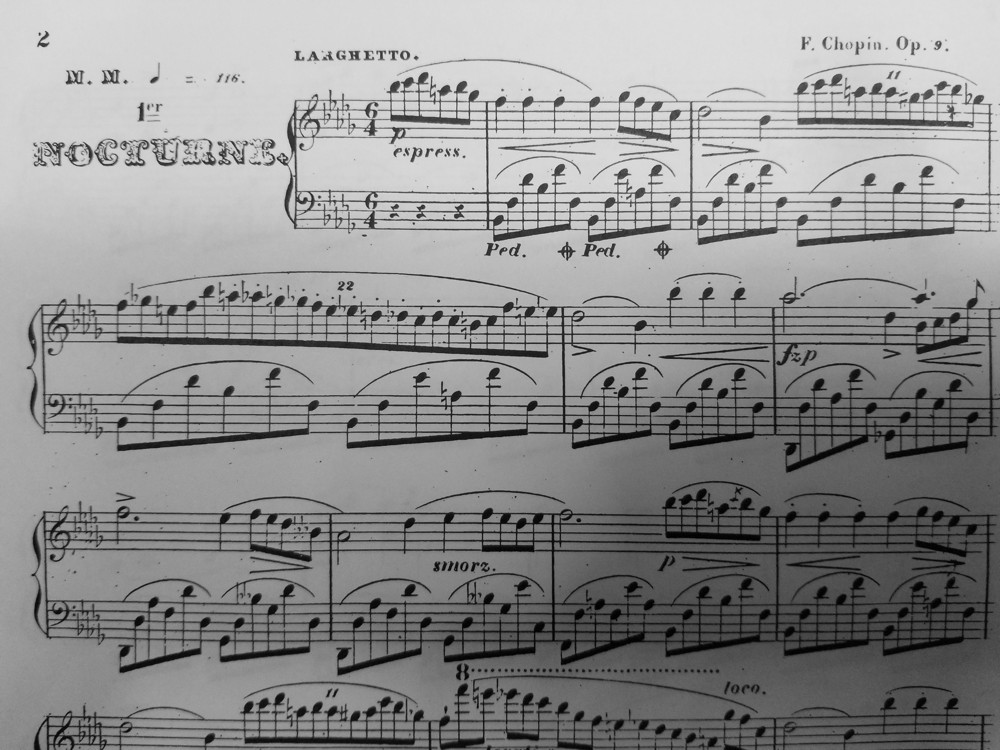

In [5]:
pim1 = Image.open(imagefile).convert('L') # pim indicates PIL image object, im indicates raw pixel values
pim1.thumbnail([resizeW, resizeH]) # modifies in place
pim1

In [6]:
def removeBkgdLighting(pimg, filtsz=5, thumbnailW = 100, thumbnailH = 100):
    tinyimg = pimg.copy()
    tinyimg.thumbnail([thumbnailW, thumbnailH]) # resize to speed up
    shadows = tinyimg.filter(ImageFilter.MaxFilter(filtsz)).resize(pimg.size)
    result = ImageChops.invert(ImageChops.subtract(shadows, pimg))
    return result

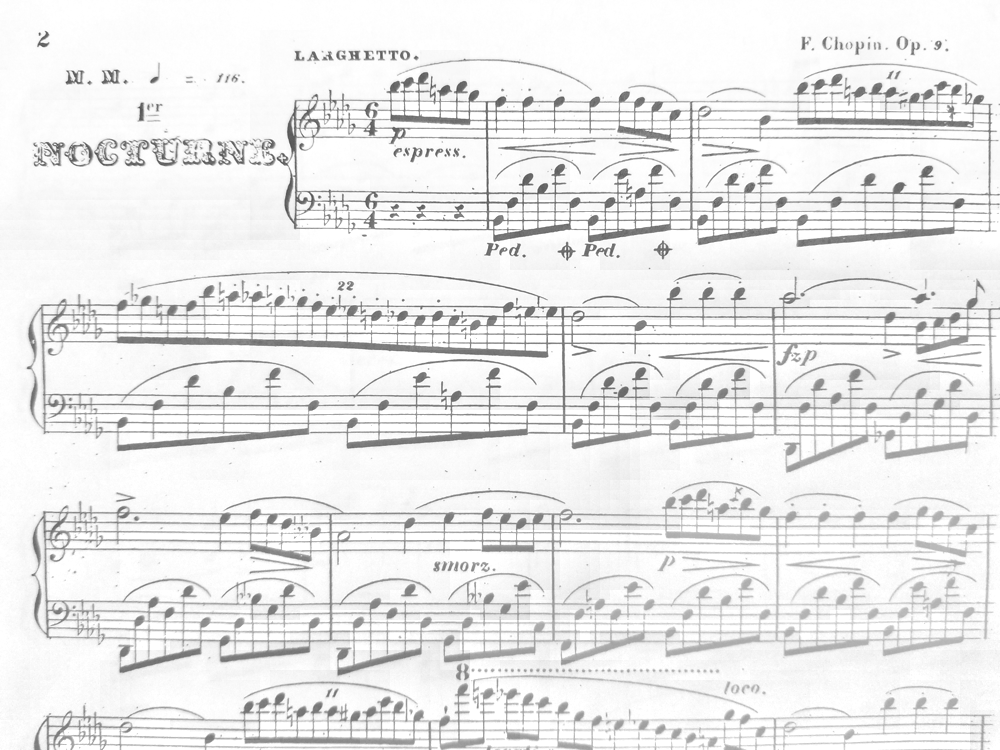

In [7]:
pim2 = removeBkgdLighting(pim1, thumbnailFilterSize, thumbnailW, thumbnailH)
pim2

In [8]:
def morphFilterCircle(pimg, sz = 5, expand = True):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (sz,sz))
    result = cv2.dilate(np.array(pimg), kernel, iterations = 1)
    if expand:
        result = cv2.erode(result, kernel, iterations = 1)
    return result

In [9]:
def showGrayscaleImage(X, sz = (10,10), maxval = 1, inverted = True):
    # by default assumes X is a normalized image between 0 (white) and 1 (black)
    plt.figure(figsize = sz)
    if inverted:
        plt.imshow(maxval-X, cmap='gray')
    else:
        plt.imshow(X, cmap='gray')

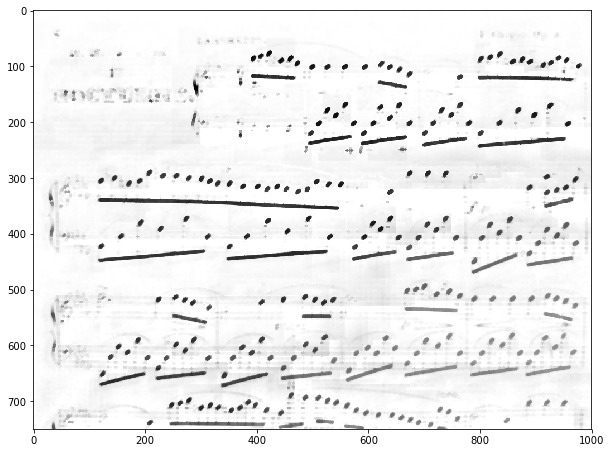

In [10]:
im3 = morphFilterCircle(pim2, morphFilterCircleSize) # from here on use raw pixel values, not PIL image object
showGrayscaleImage(im3, maxval = 255, inverted = False)

In [11]:
def detectNoteheadBlobs(img, minarea, maxarea):
    
    # define blob detector
    params = cv2.SimpleBlobDetector_Params()

    # Change thresholds
    # params.minThreshold = 100;
    # params.maxThreshold = 200;

    # Filter by Area
    # params.filterByArea = True
    params.minArea = minarea
    params.maxArea = maxarea

    # Filter by Circularity
    # params.filterByCircularity = True
    # params.minCircularity = 0.1

    # Filter by Convexity
    # params.filterByConvexity = True
    # params.minConvexity = 0.87

    # Filter by Inertia
    # params.filterByInertia = True
    # params.minInertiaRatio = 0.01

    # Create a detector with the parameters
    detector = cv2.SimpleBlobDetector_create(params)
    
    keypoints = detector.detect(img)
    im_with_keypoints = cv2.drawKeypoints(np.array(img), keypoints, np.array([]), (0,0,255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    
    return keypoints, im_with_keypoints

In [12]:
def showColorImage(X, sz = (10,10)):
    plt.figure(figsize = sz)
    plt.imshow(X)

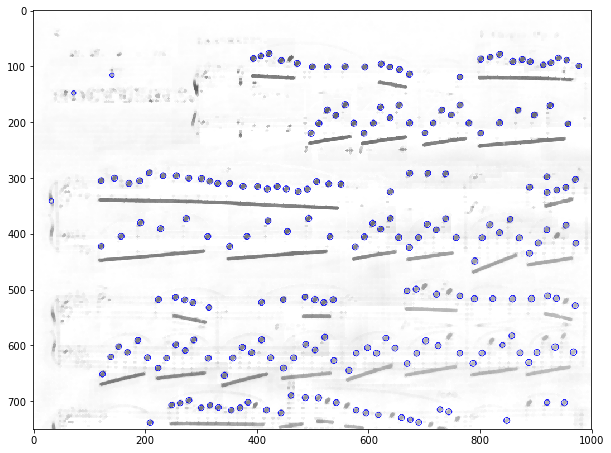

In [13]:
keypoints, im_with_keypoints = detectNoteheadBlobs(im3, notedetect_minarea, notedetect_maxarea)
showColorImage(im_with_keypoints)

In [14]:
def getNormImage(img):
    X = 1 - np.array(img) / 255.0
    return X

In [15]:
def getNoteTemplate(arr, keypoints, sz = 21):
    template = np.zeros((sz,sz))
    L = (sz - 1)//2
    crops = []
    for k in keypoints:
        xloc = int(np.round(k.pt[0])) # col
        yloc = int(np.round(k.pt[1])) # row
        if xloc - L >= 0 and xloc + L + 1 <= arr.shape[1] and yloc - L >= 0 and yloc + L + 1 <= arr.shape[0]:
            crop = arr[yloc-L:yloc+L+1,xloc-L:xloc+L+1]
            crops.append(crop)
            template += crop
    template = template / len(crops)
    #template = template - np.mean(template.ravel()) # will be used as a filter, so make zero mean
    return template, crops

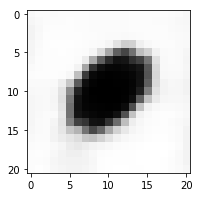

In [16]:
X3 = getNormImage(im3) # im indicates grayscale [0, 255], X indicates [0, 1] inverted grayscale
ntemplate, pcrops = getNoteTemplate(X3, keypoints, noteTemplateSize)
showGrayscaleImage(ntemplate, (3,3), maxval = 1, inverted = True)

In [17]:
# def getRandomCrops(arr, N=200, sz=21):
#     crops = np.zeros((N,sz,sz))
#     L = (sz-1)//2
#     for i in range(N):
#         yloc = np.random.randint(L, arr.shape[0]-L) # row
#         xloc = np.random.randint(L, arr.shape[1]-L) # col
#         crops[i,:,:] = arr[yloc-L:yloc+L+1,xloc-L:xloc+L+1]
#     return crops

In [18]:
# def comparePosNegDistributions(pcrops, ncrops, template):
#     pos = []
#     for crop in pcrops:
#         pos.append(np.sum(crop * template))
#     neg = []
#     for crop in ncrops:
#         neg.append(np.sum(crop*template))
#     sns.kdeplot(np.array(pos))
#     sns.kdeplot(np.array(neg))
#     return pos, neg

In [19]:
# ncrops = getRandomCrops(X3)
# pos, neg = comparePosNegDistributions(pcrops, ncrops, ntemplate)

In [20]:
def adaptiveNoteheadDetect(arr, template, noteTolRatio, chordBlockSpecs):
    #filtered = convolve2d(arr, np.flipud(np.fliplr(template)), mode='same', boundary='symm')
    binarized, thresh = binarize_otsu(arr)
    templateSpecs = getNoteTemplateSpecs(template, thresh)
    labels = measure.label(binarized)
    notes = []
    for region in regionprops(labels):
        if isValidNotehead(region, noteTolRatio, templateSpecs):
            notes.append(region.bbox)
        elif isValidChordBlock(region, chordBlockSpecs, templateSpecs):
            chordNotes = extractNotesFromChordBlock(region, templateSpecs)
            notes.extend(chordNotes)
    return notes, binarized

In [21]:
def binarize_otsu(img):
    arr = np.array(img)
    thresh = filters.threshold_otsu(arr)
    binarized = arr > thresh
    return binarized, thresh

In [22]:
def getNoteTemplateSpecs(template, thresh):
    binarized = template > thresh
    labels = measure.label(binarized)
    maxH, maxW, maxArea = (0, 0, 0)
    for region in regionprops(labels):
        curH = region.bbox[2] - region.bbox[0]
        curW = region.bbox[3] - region.bbox[1]
        curArea = region.area
        if curArea > maxArea:
            maxArea = curArea
            maxH = curH
            maxW = curW
    return (maxH, maxW, maxArea)

In [23]:
def isValidNotehead(region, tol_ratio, templateSpecs):
    templateH, templateW, templateArea = templateSpecs
    max_ratio = 1 + tol_ratio
    min_ratio = 1 / (1 + tol_ratio)
    curH = region.bbox[2] - region.bbox[0]
    curW = region.bbox[3] - region.bbox[1]
    curArea = region.area
    curRatio = 1.0 * curH / curW
    templateRatio = 1.0 * templateH / templateW
    validH = curH < templateH * max_ratio and curH > templateH * min_ratio
    validW = curW < templateW * max_ratio and curW > templateW * min_ratio
    validArea = curArea < templateArea * max_ratio * max_ratio and curArea > templateArea * min_ratio * min_ratio
    validRatio = curRatio < templateRatio * max_ratio and curRatio > templateRatio * min_ratio
    result = validH and validW and validRatio and validArea
    return result

In [24]:
def isValidChordBlock(region, params, templateSpecs):
    templateH, templateW, templateArea = templateSpecs
    minH, maxH, minW, maxW, minArea, maxArea, minNotes, maxNotes = params
    curH = region.bbox[2] - region.bbox[0]
    curW = region.bbox[3] - region.bbox[1]
    curArea = region.area
    curNotes = int(np.round(curArea / templateArea))
    validH = curH >= minH * templateH and curH <= maxH * templateH
    validW = curW >= minW * templateW and curW <= maxW * templateW
    validArea = curArea >= minArea * templateArea and curArea <= maxArea * templateArea
    validNotes = curNotes >= minNotes and curNotes <= maxNotes
    result = validH and validW and validArea and validNotes
    return result

In [25]:
def extractNotesFromChordBlock(region, templateSpecs):
    # use kmeans to estimate note centers
    templateH, templateW, templateArea = templateSpecs
    numNotes = int(np.round(region.area / templateArea))
    regionCoords = np.array(region.coords)
    kmeans = KMeans(n_clusters=numNotes, n_init = 1).fit(regionCoords)
    bboxes = []
    for (r,c) in kmeans.cluster_centers_:
        rmin = int(np.round(r - templateH/2))
        rmax = int(np.round(r + templateH/2))
        cmin = int(np.round(c - templateW/2))
        cmax = int(np.round(c + templateW/2))
        bboxes.append((rmin, cmin, rmax, cmax))
    return bboxes

In [26]:
def visualizeLabels(img, bboxes):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(img)
    
    for (minr, minc, maxr, maxc) in bboxes:
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr, fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)

    ax.set_axis_off()
    plt.tight_layout()
    plt.show()

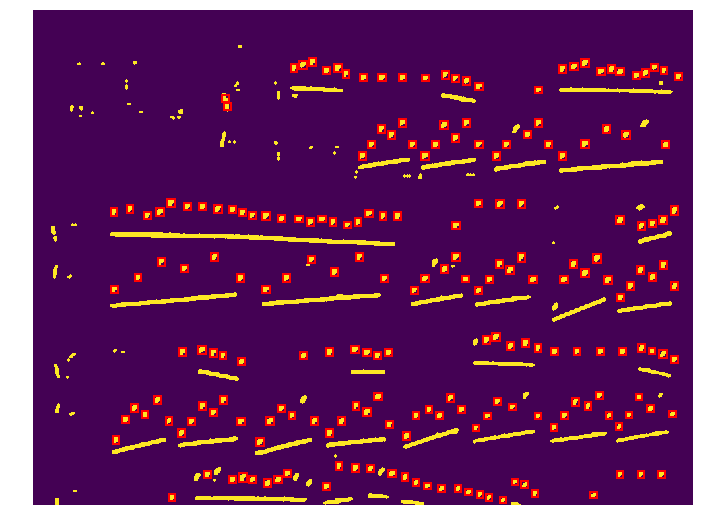

In [27]:
chordBlockSpecs = (chordBlock_minH, chordBlock_maxH, chordBlock_minW, chordBlock_maxW, chordBlock_minArea, chordBlock_maxArea, chordBlock_minNotes, chordBlock_maxNotes)
notes, img_binarized_notes = adaptiveNoteheadDetect(X3, ntemplate, notedetect_tol_ratio, chordBlockSpecs)
#showGrayscaleImage(img_binarized_notes)
visualizeLabels(img_binarized_notes, notes)

In [28]:
def getContextRegion(arr, center, deltaR = 10, deltaC = 10):
    r = int(np.round(center[0]))
    c = int(np.round(center[1]))
    rupper = min(r + deltaR + 1, arr.shape[0])
    rlower = max(r - deltaR, 0)
    cupper = min(c + deltaC + 1, arr.shape[1])
    clower = max(c - deltaC, 0)
    crop = arr[rlower:rupper,clower:cupper] 
    return crop

In [29]:
def getContextRegion2(arr, rstart, rend, cstart, cend):
    rupper = min(rend, arr.shape[0])
    rlower = max(rstart, 0)
    cupper = min(cend, arr.shape[1])
    clower = max(cstart, 0)
    crop = arr[rlower:rupper,clower:cupper] 
    return crop

In [30]:
def getNoteheadInfo(bboxes):
    nhlocs = [(.5*(bbox[0] + bbox[2]), .5*(bbox[1] + bbox[3])) for bbox in bboxes]
    nhlens = [(bbox[2] - bbox[0]) for bbox in bboxes]
    nhwidths = [(bbox[3] - bbox[1]) for bbox in bboxes]
    nhlen_est = int(np.ceil(np.mean(nhlens)))
    nhwidth_est = int(np.ceil(np.mean(nhwidths)))
    return nhlocs, nhlen_est, nhwidth_est

In [31]:
nhlocs, nhlen_est, nhwidth_est = getNoteheadInfo(notes)
nhlen_est, nhwidth_est

(12, 11)

### Staff Line Detection

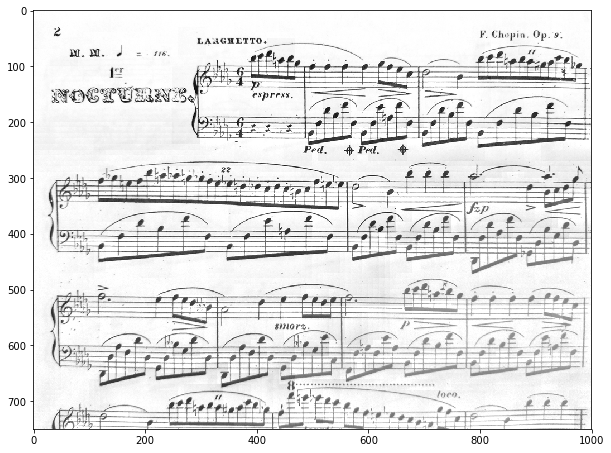

In [32]:
X2 = getNormImage(pim2)
showGrayscaleImage(X2)

In [33]:
def morphFilterLinesHoriz(arr, kernel_len = 51):
    kernel = np.ones((1,kernel_len),np.uint8)
    hlines = cv2.erode(arr, kernel, iterations = 1)
    hlines = cv2.dilate(hlines, kernel, iterations = 1)
    return hlines

In [34]:
def morphFilterLinesVert(arr, kernel_length = 51, kernel_width = 1):
    vkernel = np.ones((kernel_length, 1), np.uint8)
    hkernel = np.ones((1, kernel_width), np.uint8)
    lines = cv2.erode(arr, vkernel, iterations = 1)
    lines = cv2.dilate(lines, vkernel, iterations = 1)
    lines = cv2.dilate(lines, hkernel, iterations = 1)
    return lines

In [35]:
def isolateStaffLines(arr, kernel_len, notebarfilt_len):
    lines = morphFilterLinesHoriz(arr, kernel_len)
    notebarsOnly = morphFilterLinesVert(lines, notebarfilt_len)
    result = np.clip(lines - notebarsOnly, 0, None) # subtract out thick notebars
    return result

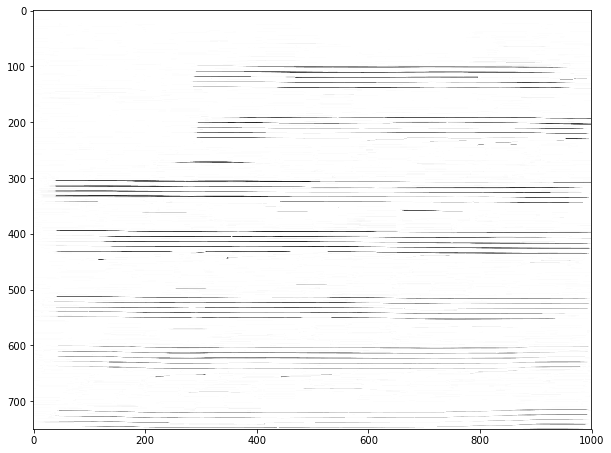

In [36]:
hlines = isolateStaffLines(X2, morphFilterHorizLineSize, notebarFiltLen)
showGrayscaleImage(hlines)

In [37]:
def createCombFilters(estNoteheadHeight, tol = .25):
    # create comb filters of different lengths
    # e.g. if length is 44, then spikes at indices 0, 11, 22, 33, 44
    # e.g. if length is 43, then spikes at 0 [1.0], 10 [.25], 11 [.75], 21 [.5], 22 [.5], 32 [.75], 33 [.25], 43 [1.0]
    stavelen_ll = int((1 - tol) * 4 * estNoteheadHeight)
    stavelen_ul = int(np.ceil((1 + tol) * 4 * estNoteheadHeight))
    stavelens = np.arange(stavelen_ll, stavelen_ul)
    combfilts = np.zeros((len(stavelens), stavelens[-1], 1))
    for i, stavelen in enumerate(stavelens):
        for j in range(5):
            idx = j * (stavelen-1) / 4.0
            idx_below = int(idx)
            idx_above = idx_below + 1
            remainder = idx - idx_below
            combfilts[i, idx_below, 0] = 1 - remainder
            if idx_above < combfilts.shape[1]:
                combfilts[i, idx_above, 0] = remainder
    return combfilts, stavelens

In [38]:
def estimateStaffLineSizes(hlines, combfilts, stavelens, numStrips = 6):
    stripWidth = hlines.shape[1] // numStrips 
    strips = hlines[:,stripWidth:stripWidth*(numStrips-1)].reshape((hlines.shape[0], stripWidth, numStrips - 2)) # exclude outer strips (page margins)
    rsums = np.sum(strips, axis=1)
    numFilters = len(stavelens)
    scores = np.zeros((numFilters, numStrips - 2))
    for i in range(numFilters):
        m = convolve2d(rsums, np.fliplr(np.flipud(combfilts[i])), mode = 'valid')
        scores[i,:] = np.max(m, axis=0)
    bestIdxs = np.argmax(scores, axis=0)
    startIdx = np.min(bestIdxs)
    endIdx = np.max(bestIdxs) + 1
    combfiltsPruned = combfilts[startIdx:endIdx,:,:]
    stavelensPruned = stavelens[startIdx:endIdx]
    return combfiltsPruned, stavelensPruned

In [39]:
def computeStaveFeatureMap(arr, combfilts, rowfiltlen):
    featmap = []
    rowfilt = np.ones((1, rowfiltlen))
    for i in range(combfilts.shape[0]):
        m = convolve2d(arr, np.fliplr(np.flipud(combfilts[i])), mode = 'valid')
        m = convolve2d(m, rowfilt, mode = 'same')
        featmap.append(m)
    featmap = np.array(featmap)
    return featmap

In [40]:
combfilts, stavelens = createCombFilters(nhlen_est, combFilterSizeTol)
combfilts, stavelens = estimateStaffLineSizes(hlines, combfilts, stavelens, staffSizeEstNumStrips)
featmap = computeStaveFeatureMap(hlines, combfilts, morphFilterHorizLineSize)

In [41]:
def getEstStaffLineLocs(featmap, nhlocs, arr, stavelens, deltaRowMax = 70, globoffset = 0):
    preds = []
    for nhloc in nhlocs:
        r = int(np.round(nhloc[0]))
        c = int(np.round(nhloc[1]))
        rupper = min(r + deltaRowMax + 1 - np.max(stavelens), arr.shape[0])
        rlower = max(r - deltaRowMax, 0)
        reg = np.squeeze(featmap[:, rlower:rupper, c])
        if len(stavelens) == 1:
            roffset = reg.argmax()
            mapidx = 0
        else:
            mapidx, roffset = np.unravel_index(reg.argmax(), reg.shape)
        rstart = rlower + globoffset + roffset
        rend = rstart + stavelens[mapidx] - 1
        preds.append((rstart, rend, c, r, mapidx))
        
    sfiltlen = int(np.round(np.median([stavelens[tup[4]] for tup in preds])))
    return preds, sfiltlen

In [42]:
def visualizeEstStaffLines(preds, arr):
    showGrayscaleImage(arr, (15,15))
    rows1 = np.array([pred[0] for pred in preds]) # top staff line
    rows2 = np.array([pred[1] for pred in preds]) # bottom staff line
    cols = np.array([pred[2] for pred in preds]) # nh col
    rows3 = np.array([pred[3] for pred in preds]) # nh row
    plt.scatter(cols, rows1, c = 'r', s = 3)
    plt.scatter(cols, rows2, c = 'b', s = 3)
    plt.scatter(cols, rows3, c = 'y', s = 3)

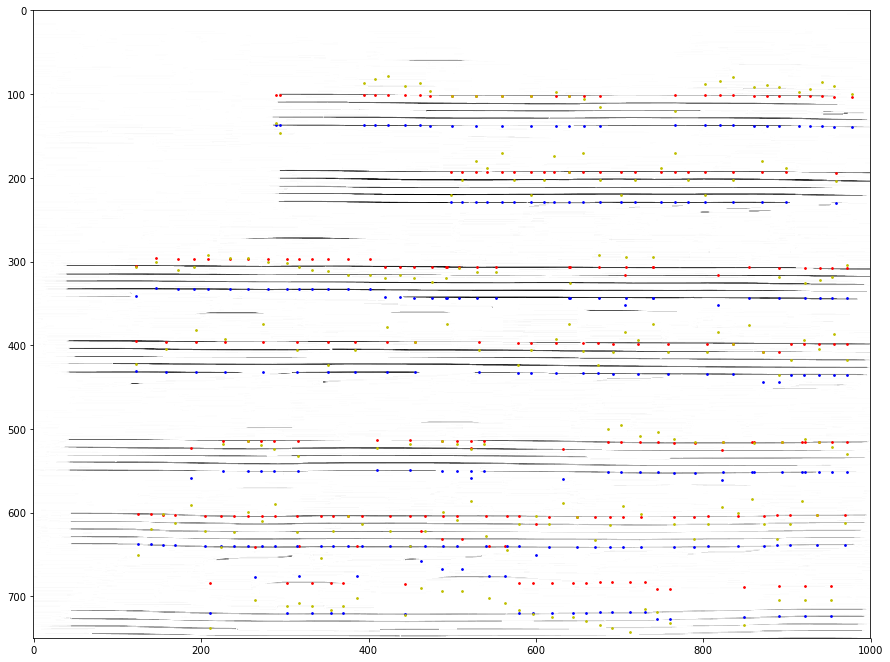

In [43]:
estStaffLineLocs, sfiltlen = getEstStaffLineLocs(featmap, nhlocs, hlines, stavelens, maxDeltaRow)
visualizeEstStaffLines(estStaffLineLocs, hlines)

In [44]:
def getStaveTemplate(arr, preds, filtlen, rbuff = 0):
    crops = np.zeros((len(preds), 2*rbuff + filtlen, 1))
    for i, tup in enumerate(preds):
        (rstart, rend, c, r, filtidx) = tup
        reg = getContextRegion2(arr, rstart - rbuff, rstart + filtlen + rbuff, c, c + 1)
        crops[i, 0:reg.shape[0], :] = reg
    template = np.mean(crops, axis=0)
    template = template - np.mean(template.ravel())
    return template, crops

In [45]:
# stemplate, scrops = getStaveTemplate(hlines, estStaffLineLocs, sfiltlen)
# showGrayscaleImage(stemplate)
# sfiltlen

### Barline Detection

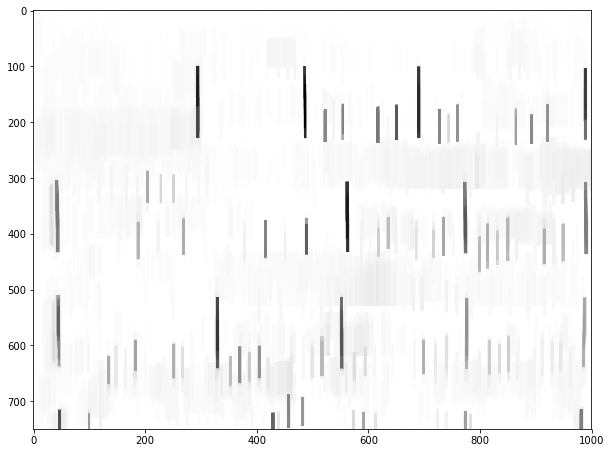

In [46]:
vlines = morphFilterLinesVert(X2, morphFilterVertLineLength, morphFilterVertLineWidth)
showGrayscaleImage(vlines)

In [47]:
def estimateBarlineThreshold(heights, maxVal):
    pruned = np.array([h for h in heights if h < maxVal]) # toss out outliers (probably shadows)
    if len(pruned) > 1:
        thresh = filters.threshold_otsu(np.expand_dims(pruned, axis=0))
    else:
        thresh = 0
    return thresh

In [48]:
def isValidBarline(region, minBarlineLen, maxBarlineLen, maxBarlineWidth):
    height = region.bbox[2] - region.bbox[0]
    width = region.bbox[3] - region.bbox[1]
    aboveMin = height > minBarlineLen
    belowMaxLen = height < maxBarlineLen
    belowMaxWidth = width < maxBarlineWidth
    result = aboveMin and belowMaxLen and belowMaxWidth
    return result

In [49]:
def barlineDetect(arr, maxBarlineLen = 200, maxBarlineWidth = 10):
    binarized, _ = binarize_otsu(arr)
    labels = measure.label(binarized)
    heights = [region.bbox[2] - region.bbox[0] for region in regionprops(labels)]
    minBarlineLen = estimateBarlineThreshold(heights, maxBarlineLen)
    bars = []
    for region in regionprops(labels):
        if isValidBarline(region, minBarlineLen, maxBarlineLen, maxBarlineWidth):
            bars.append(region.bbox)
    return bars, binarized

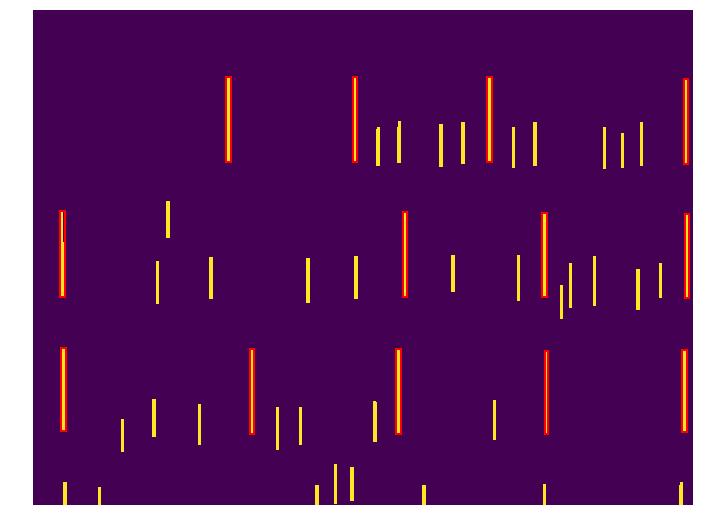

In [50]:
maxBarlineLen = int(vlines.shape[0] * maxBarlineLenFactor)
bars, img_binarized_bars = barlineDetect(vlines, maxBarlineLen, maxBarlineWidth)
visualizeLabels(img_binarized_bars, bars)

In [51]:
def calcOverlap(seg1, seg2):
    lb = max(seg1[0], seg2[0])
    ub = min(seg1[1], seg2[1])
    overlap = np.clip(ub - lb, 0, None)
    return overlap

In [52]:
def clusterBarlines(bars):
    
    # cluster overlapping barlines
    clusters = -1*np.ones(len(bars), dtype=np.int8)
    clusterIndex = 0
    for i in range(len(bars)):
        if clusters[i] == -1: # has not been assigned a cluster yet
            anchor = (bars[i][0], bars[i][2])
            for j in range(i,len(bars)):
                other = (bars[j][0], bars[j][2])
                overlap = calcOverlap(anchor, other)
                if overlap > 0:
                    clusters[j] = clusterIndex
            clusterIndex += 1
    
    # determine bounds of each cluster
    cluster_bnds = []
    for i in range(clusterIndex):
        selected = np.array([(reg[0], reg[2]) for j, reg in enumerate(bars) if clusters[j] == i])
        lb = np.min(selected)
        ub = np.max(selected)
        cluster_bnds.append((lb, ub))
    
    return clusters, cluster_bnds

In [53]:
def visualizeBarClusters(arr, clusters):
    showGrayscaleImage(arr, (5,5))
    ax = plt.gca()
    minc = 0
    maxc = arr.shape[1] - 1
    for (minr, maxr) in clusters:
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr, fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)
    ax.set_axis_off()
    plt.tight_layout()

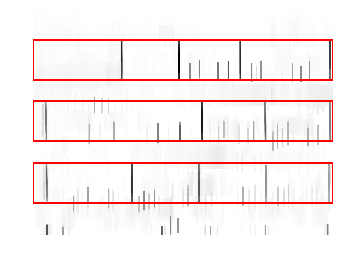

In [54]:
barline_clusters, barline_clusterbnds = clusterBarlines(bars)
visualizeBarClusters(vlines, barline_clusterbnds)

### Cluster and Label Noteheads

In [55]:
def estimateNoteLabels(preds, staveH):
    midpts  = [((.5 * (tup[0] + tup[1])), tup[2]) for tup in preds] # stave midpt locations (row, col)
    tree = KDTree(np.array(midpts)) # use kdtree to find nearest neighbors
    nhvals = [] # estimated note labels
    midpts2 = [] # updated estimate of nearest stave midpoints (stave assignment may change)
    for i, (rstart, rend, c, r, filtidx) in enumerate(preds):
        _, idx = tree.query((r,c), k=1)
        midpt_row = midpts[idx][0] # row location of nearest stave midpoint
        nhval = estimateNoteStaveLoc(r, midpt_row, staveH)
        nhvals.append(nhval)
        midpts2.append(midpt_row)
    return nhvals, midpts2

In [56]:
def estimateNoteStaveLoc(r, r0, staveH):
    # if a stave has height L, there are 8 stave locations in (L-1) pixel rows
    noteStaveLoc = -1.0 * (r - r0) * 8 / (staveH - 1)
    discretized = int(np.round(noteStaveLoc))
    return discretized

In [57]:
def visualizeNoteLabels(arr, vals, locs):
    showGrayscaleImage(arr)
    rows = np.array([loc[0] for loc in locs])
    cols = np.array([loc[1] for loc in locs])
    plt.scatter(cols, rows, color='blue')
    for i in range(len(rows)):
        plt.text(cols[i], rows[i] - 15, str(vals[i]), fontsize = 12, color='red')

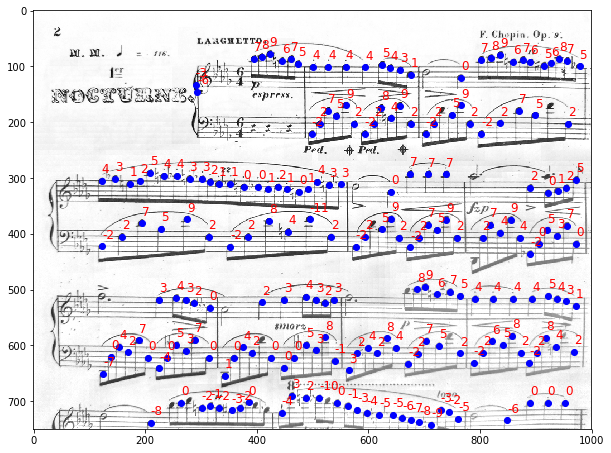

In [58]:
nhvals, nhmidpts = estimateNoteLabels(estStaffLineLocs, sfiltlen)
visualizeNoteLabels(X2, nhvals, nhlocs)

In [59]:
def clusterNoteheads(midpts, barlines):
    clusters = np.zeros(len(midpts), dtype=np.int8) # cluster index of each note
    for i, midpt in enumerate(midpts):
        clusteridx = -1 # -1 means notehead is not within a valid barline region
        for j, (lb, ub) in enumerate(barlines):
            if midpt >= lb and midpt <= ub:
                lb_dist = np.abs(midpt - lb)
                ub_dist = np.abs(midpt - ub)
                if lb_dist < ub_dist: # rh staff
                    clusteridx = 2*j
                else:
                    clusteridx = 2*j + 1 # lh staff
                break
        clusters[i] = clusteridx     
    return clusters

In [60]:
def getClusterPairs(nhclusters, numLines):
    # discard any "lines" that have no notes (may be a shadow)
    validClusterIdxs = set(nhclusters)    
    result = []
    for i in range(0, 2*numLines, 2):
        if i in validClusterIdxs or i+1 in validClusterIdxs:
            result.append((i,i+1))
    result = np.array(result)
    return result

In [61]:
def visualizeClusters(arr, preds, clusters):
    showGrayscaleImage(arr)
    rows = np.array([tup[3] for tup in preds])
    cols = np.array([tup[2] for tup in preds])
    plt.scatter(cols, rows, c=clusters)
    for i in range(len(clusters)):
        plt.text(cols[i], rows[i] - 15, str(clusters[i]), fontsize = 12, color='red')

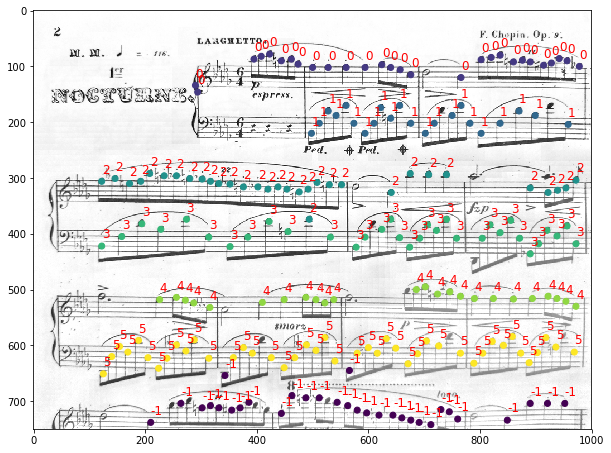

In [62]:
nhclusters = clusterNoteheads(nhmidpts, barline_clusterbnds)
clusterPairs = getClusterPairs(nhclusters, len(barline_clusterbnds))
visualizeClusters(X2, estStaffLineLocs, nhclusters)

### Generate Bootleg Score

In [63]:
def generateSingleBootlegLine(nhdata, clusterR, clusterL, minColDiff, repeatNotes = 1, filler = 1):
    notes = [tup for tup in nhdata if tup[3] == clusterR or tup[3] == clusterL]
    notes = sorted(notes, key = lambda tup: (tup[1], tup[0])) # sort by column, then row
    collapsed = collapseSimultaneousEvents(notes, nhwidth_est) # list of (rows, cols, vals, clusters)
    bscore, eventIndices, staffLinesBoth, _, _ = constructBootlegScore(collapsed, clusterR, clusterL, repeatNotes, filler)
    return bscore, collapsed, eventIndices, staffLinesBoth

In [64]:
def collapseSimultaneousEvents(notes, minColDiff):
    assigned = np.zeros(len(notes), dtype=bool)
    events = [] # list of simultaneous note events
    for i, (row, col, val, cluster) in enumerate(notes):
        if assigned[i]: # has already been assigned
            continue
        rows = [row] # new event
        cols = [col]
        vals = [val]
        clusters = [cluster]
        assigned[i] = True
        for j in range(i+1, len(notes)):
            nrow, ncol, nval, ncluster = notes[j]
            if ncol - col < minColDiff: # assign to same event if close
                rows.append(nrow)
                cols.append(ncol)
                vals.append(nval)
                clusters.append(ncluster)
                assigned[j] = True
            else:
                break
        events.append((rows, cols, vals, clusters))
    
    assert(np.all(assigned))
    return events

In [65]:
def constructBootlegScore(noteEvents, clusterIndexRH, clusterIndexLH, repeatNotes = 1, filler = 1):
    # note that this has to match generateBootlegScore() in the previous notebook!
    rh_dim = 34 # E3 to C8 (inclusive)
    lh_dim = 28 # A1 to G4 (inclusive)
    rh = [] # list of arrays of size rh_dim
    lh = [] # list of arrays of size lh_dim
    eventIndices = [] # index of corresponding simultaneous note event
    for i, (rows, cols, vals, clusters) in enumerate(noteEvents):
        
        # insert empty filler columns between note events
        if i > 0:
            for j in range(filler):
                rh.append(np.zeros((rh_dim,1)))
                lh.append(np.zeros((lh_dim,1)))
                eventIndices.append(i-1) # assign filler to previous event

        # insert note events columns
        rhvec, lhvec = getNoteheadPlacement(vals, clusters, rh_dim, lh_dim, clusterIndexRH, clusterIndexLH)
        for j in range(repeatNotes):
            rh.append(rhvec)
            lh.append(lhvec)
            eventIndices.append(i)
    rh = np.squeeze(np.array(rh)).reshape((-1, rh_dim)).T # reshape handles case when len(rh) == 1
    lh = np.squeeze(np.array(lh)).reshape((-1, lh_dim)).T
    both = np.vstack((lh, rh))
    staffLinesRH = [7,9,11,13,15]
    staffLinesLH = [13,15,17,19,21]
    staffLinesBoth = [13,15,17,19,21,35,37,39,41,43]
    return both, eventIndices, staffLinesBoth, (rh, staffLinesRH), (lh, staffLinesLH)

In [66]:
def getNoteheadPlacement(vals, clusters, rdim, ldim, clusterRH, clusterLH):
    rhvec = np.zeros((rdim, 1))
    lhvec = np.zeros((ldim, 1))
    assert(clusterLH == clusterRH + 1)
    for (val, cluster) in zip(vals, clusters):
        if cluster == clusterRH:
            idx = val + 11
            if idx >= 0 and idx < rdim:
                rhvec[idx, 0] = 1
        elif cluster == clusterLH:
            idx = val + 17
            if idx >= 0 and idx < ldim:
                lhvec[idx, 0] = 1
        else:
            print("Invalid cluster: {} (LH {}, RH {})".format(cluster, clusterLH, clusterRH))
            sys.exit(1)
    return rhvec, lhvec

In [67]:
def visualizeBootlegScore(bs, lines):
    plt.figure(figsize = (10,10))
    plt.imshow(1 - bs, cmap = 'gray', origin = 'lower')
    for l in range(1, bs.shape[0], 2):
        plt.axhline(l, c = 'grey')
    for l in lines:
        plt.axhline(l, c = 'r')

In [68]:
# list of (row, col, value, cluster) tuples
nhdata = [(int(np.round(nhlocs[i][0])), int(np.round(nhlocs[i][1])), nhvals[i], nhclusters[i]) for i in range(len(nhlocs))]

In [69]:
# bscore, events, eventIndices, staffLinesBoth = generateSingleBootlegLine(nhdata, clusterR = 2, clusterL = 3, minColDiff = nhwidth_est, repeatNotes = 1, filler = 1)
# visualizeBootlegScore(bscore, staffLinesBoth)

In [70]:
def generateQueryBootlegScore(nhdata, pairings, repeatNotes = 1, filler = 1, minColDiff = 10):
    allScores = []
    allEvents = []
    globIndices = []
    eventCount = 0
    for i, (clusterR, clusterL) in enumerate(pairings):
        score, events, eventIndices, staffLinesBoth = generateSingleBootlegLine(nhdata, clusterR, clusterL, minColDiff, repeatNotes, filler)
        allScores.append(score)
        allEvents.extend(events)
        globIndices.extend([idx + eventCount for idx in eventIndices])
        if i < len(pairings) - 1:
            allScores.append(np.zeros((score.shape[0], filler))) # append filler columns between bootleg scores
            globIndices.extend([globIndices[-1]] * filler) # map filler columns to last event index
        eventCount += len(events)
    panorama = np.hstack(allScores)
    return panorama, allEvents, globIndices, staffLinesBoth

In [71]:
def visualizeLongBootlegScore(bs, lines, chunksz = 150):
    chunks = bs.shape[1] // chunksz + 1
    for i in range(chunks):
        startcol = i * chunksz
        endcol = min((i + 1)*chunksz, bs.shape[1])
        visualizeBootlegScore(bs[:,startcol:endcol], lines)

In [72]:
bscore_query, events, eventIndices, staffLinesBoth = generateQueryBootlegScore(nhdata, clusterPairs, bootlegRepeatNotes, bootlegFiller, minColDiff = nhwidth_est)

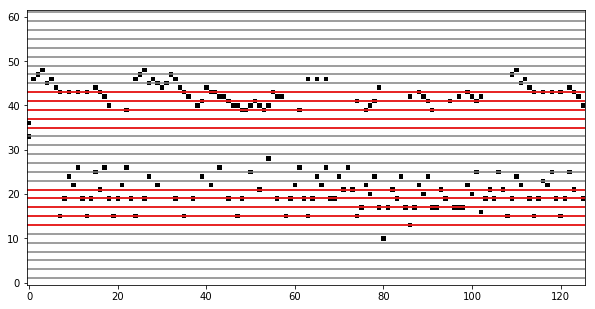

In [73]:
visualizeLongBootlegScore(bscore_query, staffLinesBoth)

In [74]:
def compressBootlegScore(bscore):
    assert bscore.shape[0] <= 64
    compressed = np.zeros(bscore.shape[1], dtype=np.uint64)
    binary2bit = np.power(2,np.arange(bscore.shape[0])).astype(np.uint64).reshape((1,-1))
    compressed = np.squeeze(np.matmul(binary2bit, bscore)).astype(np.uint64)
    return compressed

In [75]:
bscore_query_compressed = compressBootlegScore(bscore_query)

### Align bootleg scores

In [76]:
def loadDB(pkl_file, imagefile, db_size = None):
    
    with open(pkl_file, 'rb') as f:
        d = pickle.load(f) 
    return d
        
#     if db_size is None: # full database
#         result = d
#     elif db_size == 1: # assume piece is known
#         result = {}
#         pieceid = os.path.basename(imagefile).split('_')[0] # e.g. 'p4'
#         result[pieceid] = d[pieceid]
#     else:
#         assert False, 'Not implemented yet!'
#        
#    return result

In [77]:
def costMetric(X,Y):
    cost = -1 * np.dot(X,Y)
    return cost

In [78]:
def normalizedCostMetric(Q, R, numQueryNotes, numRefNotes):
    cost = -1 * np.matmul(Q.T, R)
    query_norm_factor = repmat(numQueryNotes.reshape((-1,1)), 1, R.shape[1])
    ref_norm_factor = repmat(numRefNotes.reshape((1,-1)), Q.shape[1], 1)
    norm_factor = np.maximum(query_norm_factor, ref_norm_factor) + 1e-8 # avoid divide by 0
    norm_cost = cost / norm_factor
    return norm_cost

In [79]:
def normalizedCostMetric_compressed(Q, R, numQueryNotes, numRefNotes):
    
    # calc cost matrix
    lenQ, lenR = len(Q), len(R)
    cost = np.zeros((lenQ, lenR), dtype = np.uint64)
#     for i in range(lenQ):
#         q = Q[i]
#         for j in range(lenR):
#             r = R[j]
#             cost[i,j] = -1*bin(np.bitwise_and(q, r)).count("1")
    calcCostMatrix_compressed(Q, R, cost)
    
    # normalize
    query_norm_factor = repmat(numQueryNotes.reshape((-1,1)), 1, lenR)
    ref_norm_factor = repmat(numRefNotes.reshape((1,-1)), lenQ, 1)
    norm_factor = np.maximum(query_norm_factor, ref_norm_factor) + 1e-8 # avoid divide by 0
    norm_cost = -1.0 * cost / norm_factor
    
    return norm_cost

In [80]:
def calcNumQueryNotes(seq):
    cnts = np.zeros(len(seq))
    for i, s in enumerate(seq):
        cnts[i] = bin(s).count("1")
    return cnts

In [81]:
def alignBootlegScores(query, ref, numRefNotes, steps = [1,1,1,2,2,1], weights = [1,1,2], optimized=True):
    if optimized: # Cython implementation
        # set params
        assert len(steps) % 2 == 0, "The length of steps must be even."
        dn = np.array(steps[::2], dtype=np.uint32)
        dm = np.array(steps[1::2], dtype=np.uint32)
        dw = weights
        subsequence = True
        parameter = {'dn': dn, 'dm': dm, 'dw': dw, 'SubSequence': subsequence}

        # Compute cost matrix
        #cost = costMetric(query.T, ref)
        #numQueryNotes = np.sum(query, axis=0)
        #cost = normalizedCostMetric(query, ref, numQueryNotes, numRefNotes)
        numQueryNotes = calcNumQueryNotes(query)
        cost = normalizedCostMetric_compressed(query, ref, numQueryNotes, numRefNotes)

        # DTW
        [D, s] = dtw.DTW_Cost_To_AccumCostAndSteps(cost, parameter)
        [wp, endCol, endCost] = dtw.DTW_GetPath(D, s, parameter)

        # Reformat the output
        wp = wp.T[::-1]
    else: # librosa implementation
        steps = np.array(steps).reshape((-1,2))
        D, wp = lb.sequence.dtw(query, ref, step_sizes_sigma = steps, weights_mul = weights, subseq = True, metric = costMetric)
    return D, wp

In [82]:
def plotAlignment(D, wp, seginfo = None):
    plt.figure(figsize = (10,10))
    plt.imshow(D, origin = 'lower', cmap = 'jet')
    plt.plot(wp[:,1], wp[:,0], color='y')
    plt.xlabel('Ref')
    plt.ylabel('Query')
    if seginfo is not None:
        matchSegTime, refSegTimes, refSegCols = seginfo
        for i, refSegCol in enumerate(refSegCols):            
            plt.axvline(refSegCol[0], color = 'm')
            plt.axvline(refSegCol[1], color = 'm')
        plt.title('Hyp ({:.1f} s, {:.1f} s), Ref ({:.1f} s, {:.1f} s)'.format(matchSegTime[0], matchSegTime[1], refSegTimes[0][0], refSegTimes[0][1]))
    else:
        plt.title('Subsequence DTW Alignment')

In [83]:
def getPredictedTimestamp(midi_frm, times):
    midi_time = times[midi_frm][0] # in sec
    midi_tick = times[midi_frm][1] # in ticks
    return midi_time, midi_tick

In [84]:
def getGroundTruthTimestamps(imgfile, col2times):
    
    # get ground truth start, end times
    query = os.path.splitext(os.path.basename(imgfile))[0] # e.g. '/path/to/dir/p1_q10.jpg'
    query_gt_file = 'data/query_info/query.gt'
    refmatchesTime = []
    with open(query_gt_file, 'r') as f:
        for line in f:
            parts = line.rstrip().split(',')
            if parts[0] == query:
                tstart = float(parts[1])
                tend = float(parts[2])
                refmatchesTime.append((tstart, tend))
    
    # get start, end columns in bootleg score
    bscore_cols = np.arange(len(col2times))
    times = [tup[0] for tup in col2times]
    refmatchesCol = []
    for (tstart, tend) in refmatchesTime:
        col_start, col_end = np.interp([tstart, tend], times, bscore_cols)
        refmatchesCol.append((col_start, col_end))
    
    return refmatchesTime, refmatchesCol

In [85]:
def searchDB_dtw(bscore_query, db, dtw_steps, dtw_weights):
    # run subsequence dtw against each item in the database
    results = [] # list of (pieceid, score, tstart, tend) tuples
    for piece_id in db:
        bscore_midi = db[piece_id]['bscore']
        miditimes = db[piece_id]['times']
        num_notes = np.array(db[piece_id]['num_notes'])
        D, wp = alignBootlegScores(bscore_query, bscore_midi, num_notes, dtw_steps, dtw_weights)
        matchSegmentTimeStart, _ = getPredictedTimestamp(wp[-1,1], miditimes)
        matchSegmentTimeEnd, _ = getPredictedTimestamp(wp[0,1], miditimes)
        results.append((piece_id, D[-1,:].min(), matchSegmentTimeStart, matchSegmentTimeEnd, wp)) 
    results.sort(key = lambda x: x[1])
    return results 

In [86]:
def getLocalOffset(global_offset, boundaries):
    for i in range(len(boundaries)):
        if boundaries[i+1] > global_offset:
            pieceIdx = i
            break
    local_offset = global_offset - boundaries[pieceIdx]
    return pieceIdx, local_offset

In [87]:
def inferMatchInfo(wp, boundaries, pieces):
    
    # determine matching piece index and local offsets
    start_frm_global = wp[-1,1]
    end_frm_global = wp[0,1]
    start_piece, start_offset = getLocalOffset(start_frm_global, boundaries)
    end_piece, end_offset = getLocalOffset(end_frm_global, boundaries)
    
    # handle case when matching segment overlaps two different pieces
    if start_piece == end_piece:
        result = (start_piece, start_offset, end_offset)
    else:
        candidates = []
        for i in range(start_piece, end_piece + 1):
            overlap = calcOverlap((boundaries[i], boundaries[i+1]), (start_frm_global, end_frm_global + 1))
            candidates.append((i, overlap))
        candidates.sort(key=lambda x: x[1], reverse=True)
        selected_piece = candidates[0][0] # index of piece with most overlap
        overlap_start = max(start_frm_global, boundaries[selected_piece])
        overlap_end = min(end_frm_global, boundaries[selected_piece+1] - 1)
        result = (selected_piece, overlap_start - boundaries[selected_piece], overlap_end - boundaries[selected_piece])
    return result

In [88]:
def getMidiTimeMapping(piece_id, db_dir):
    pkl_file = '{}/{}.pkl'.format(db_dir, piece_id)
    with open(pkl_file, 'rb') as f:
        d = pickle.load(f)
    mapping = d['times']
    return mapping

### Cython optimized search

In [89]:
%load_ext Cython

In [90]:
%%cython -a
import numpy as np
cimport numpy as np
cimport cython
from libc.stdint cimport uint64_t

cdef extern int __builtin_popcountll(unsigned long long) nogil

@cython.boundscheck(False)
@cython.wraparound(False)
def calcCostMatrix_compressed(uint64_t[::1] qseq, uint64_t[::1] rseq, uint64_t[:, ::1] C):
    cdef int i, j
    cdef uint64_t[:, ::1] C_view = C
    cdef uint64_t[::1] q_view = qseq
    cdef uint64_t[::1] r_view = rseq
    for i in xrange(qseq.shape[0]):
        for j in xrange(rseq.shape[0]):
            C_view[i, j] = __builtin_popcountll(q_view[i] & r_view[j])

In [91]:
N = 1000000
%timeit -n3 -r3 calcCostMatrix_compressed(np.zeros(100, dtype = np.uint64), np.zeros(N, dtype = np.uint64), np.zeros((100,N), dtype = np.uint64))

856 ms ± 4.07 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)


In [92]:
def searchDB_compressed_dtw(query_compressed, db, dtw_steps, dtw_weights, db_dir):
    
    # run subsequence dtw against concatenated, compressed db sequence
    data = db['data']
    num_notes = db['num_notes']
    boundaries = db['boundaries']
    pieces = db['pieces']
    D, wp = alignBootlegScores(query_compressed, data, num_notes, dtw_steps, dtw_weights)
    
    # get hypothesis
    pieceIdx, start_frm, end_frm = inferMatchInfo(wp, boundaries, pieces)
    piece_id = pieces[pieceIdx]
    miditimes = getMidiTimeMapping(piece_id, db_dir)
    matchSegmentTimeStart, _ = getPredictedTimestamp(start_frm, miditimes)
    matchSegmentTimeEnd, _ = getPredictedTimestamp(end_frm, miditimes)
    results = []
    results.append((piece_id, D[-1,:].min(), matchSegmentTimeStart, matchSegmentTimeEnd, wp))
    
    return results 

In [120]:
db_file = 'experiments/search5/db/db.pkl'
db = loadDB(db_file, imagefile)
db_dir = '{}/single'.format(os.path.dirname(db_file))
#results = searchDB_compressed_dtw(bscore_query_compressed, db, dtw_steps, dtw_weights, db_dir)

In [115]:
%timeit -n1 -r1 results = searchDB_compressed_dtw(bscore_query_compressed, db, dtw_steps, dtw_weights, db_dir)

1min 48s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [116]:
len(db['data'])

14014761

In [117]:
len(db['pieces'])

20062

In [119]:
results

[('p1', -107.49999915750003, 0.0, 29.224173, array([[125, 145],
         [124, 144],
         [123, 143],
         [122, 142],
         [121, 141],
         [120, 140],
         [119, 139],
         [118, 138],
         [117, 137],
         [116, 136],
         [115, 135],
         [114, 134],
         [113, 133],
         [112, 131],
         [111, 130],
         [110, 129],
         [109, 128],
         [108, 127],
         [107, 126],
         [106, 125],
         [105, 124],
         [104, 123],
         [102, 122],
         [101, 120],
         [100, 118],
         [ 99, 117],
         [ 98, 116],
         [ 97, 115],
         [ 96, 114],
         [ 95, 113],
         [ 94, 112],
         [ 93, 111],
         [ 92, 110],
         [ 91, 108],
         [ 90, 107],
         [ 89, 106],
         [ 88, 105],
         [ 87, 104],
         [ 86, 103],
         [ 85, 102],
         [ 84, 101],
         [ 83, 100],
         [ 82,  99],
         [ 81,  98],
         [ 80,  97],
         [ 7

### begin experiment

In [126]:
# def binary2int(bscore):
#     mult = np.power(2,np.arange(62)).reshape((1,-1))
#     result = np.squeeze(np.matmul(mult, bscore)).astype(np.uint64)
#     return result

In [127]:
# def computeBoundedCostMatrix(midiseq, model_file):
    
#     # load search region model
#     with open(model_file, 'rb') as f:
#         rowRanges = pickle.load(f)
    
#     midi_len = len(midiseq)
#     query_len = len(rowRanges) # max allowable chunk size
#     R = np.zeros((query_len, midi_len), dtype = np.uint64)
#     for j, (offset_start, offset_end) in enumerate(rowRanges):
#         for offset in range(offset_start, offset_end):
#             chunk = midiseq[offset:]
#             chunkLen = len(chunk)
#             R[j,0:chunkLen] = np.bitwise_or(R[j,0:chunkLen], chunk)
#     return R

In [128]:
# def calcNormFactors(midi_len, bscore_query, num_notes):
#     query_len = bscore_query.shape[1]
#     norm_factors = np.zeros(midi_len)
#     for i in range(midi_len):
#         accum = 0
#         for j in range(query_len):
#             if i+j < midi_len:
#                 accum += num_notes[i+j]
#         norm_factors[i] = accum
#     numQueryNotes = np.sum(np.sum(bscore_query))
#     norm_factors_max = np.maximum(norm_factors, numQueryNotes)
#     return norm_factors_max, norm_factors, numQueryNotes

In [129]:
# def computeMatchScores(midiseq_agg, queryseq, num_notes):
    
#     # convert to int representation
#     midi_len = midiseq_agg.shape[1]
#     query_len = len(queryseq)
    
#     # count bit overlap
#     assert(midiseq_agg.shape[0] >= query_len)
#     R = midiseq_agg[0:query_len,:]
#     bitAnd = np.bitwise_and(R, queryseq.reshape(-1,1))
#     counts_unnorm = np.zeros(midi_len)
#     for i in range(midi_len):
#         accum = 0
#         for j in range(query_len):
#             accum += bin(bitAnd[j,i]).count("1")
#         counts_unnorm[i] = accum
    
#     # normalize by note count
#     #norm_factors, norm_factors_nomax, numQueryNotes = calcNormFactors(midi_len, bscore_query, num_notes)
#     #counts_norm = counts_unnorm / norm_factors
    
#     #return counts_norm, counts_unnorm, norm_factors_nomax, numQueryNotes
#     return counts_unnorm

In [130]:
# def visualizeScores(dtwScores, normScores, unnormScores, norm_factors_nomax, numQueryNotes):
#     plt.figure(figsize=(20,6))
#     plt.subplot(1,2,1)
#     plt.plot(norm_factors_nomax)
#     plt.axhline(numQueryNotes)
#     plt.subplot(1,2,2)
#     plt.plot(unnormScores/unnormScores.max(), 'b')
#     #plt.plot(dtwScores / dtwScores.min(), 'g')
#     plt.plot(-1*normScores/normScores.max(), 'r')

In [131]:
# def searchDB_dtw_bounded(bscore_query_compressed, db, dtw_steps, dtw_weights, chunk_sz = 40):
#     # run fast, bounded approximation of subsequence dtw
#     results = [] # list of (pieceid, score, tstart, tend) tuples
#     for piece_id in db:
#         bscore_midi_agg = db[piece_id]['aggregated']
#         miditimes = db[piece_id]['times']
#         num_notes = np.array(db[piece_id]['num_notes'])
#         numChunks = len(bscore_query_compressed) // chunk_sz
#         scores = np.zeros((numChunks, bscore_midi_agg.shape[1]))
#         for i in range(numChunks):
#             scores[i,:] = computeMatchScores(bscore_midi_agg, bscore_query_compressed[i*chunk_sz:(i+1)*chunk_sz], num_notes)
#         #D, wp = alignBootlegScores(bscore_query, bscore_midi, num_notes, dtw_steps, dtw_weights)
#         total_score = -1.0*np.sum(np.max(scores, axis=1))
#         hyp_start_frm = np.argmax(scores[0,:])
#         hyp_end_frm = min(hyp_start_frm + len(bscore_query_compressed), bscore_midi_agg.shape[1] - 1)
#         #print('start {}, end {}, total {}'.format(hyp_start_frm, hyp_end_frm, bscore_midi_agg.shape[1]))
#         matchSegmentTimeStart, _ = getPredictedTimestamp(hyp_start_frm, miditimes)
#         matchSegmentTimeEnd, _ = getPredictedTimestamp(hyp_end_frm, miditimes)
#         results.append((piece_id, total_score, matchSegmentTimeStart, matchSegmentTimeEnd, None)) 
#     results.sort(key = lambda x: x[1])
#     return results 

In [132]:
# db = loadDB(db_file, imagefile)
# bscore_query_compressed = binary2int(bscore_query)
# results = searchDB_dtw_bounded(bscore_query_compressed, db, dtw_steps, dtw_weights, chunk_sz = 40)

In [133]:
#plt.stem([r[1] for r in results])

In [ ]:
#refSegmentTimes, refSegmentCols = getGroundTruthTimestamps(imagefile, miditimes)
#plotAlignment(D, wp, (matchSegmentTime, refSegmentTimes, refSegmentCols))

In [ ]:
# def visualizeAlignedBScores(s1, s2, wp, lines):
#     idxs1 = wp[::-1, 0]
#     warped1 = s1[:,idxs1]
#     idxs2 = wp[::-1, 1]
#     warped2 = s2[:,idxs2]
#     stacked = np.vstack((warped2, warped1))
#     allLines = []
#     allLines.extend(lines)
#     allLines.extend(np.array(lines) + s1.shape[0])
#     visualizeLongBootlegScore(stacked, allLines)

In [ ]:
#visualizeAlignedBScores(bscore_query, bscore_midi, wp, stafflines)

In [ ]:
# visualize alignment between query and ground truth reference segment
# refColStart = int(refSegmentCols[0][0])
# refColEnd = int(refSegmentCols[0][1])
# bscore_midi_refseg = bscore_midi[:,refColStart:refColEnd]
# D2, wp2 = alignBootlegScores(bscore_query, bscore_midi_refseg, num_notes[refColStart:refColEnd])
# visualizeAlignedBScores(bscore_query, bscore_midi_refseg, wp2, stafflines)

### Run system on all files

In [121]:
def processQuery(imagefile, db_file, outfile = None):

    ### system parameters ###
    resizeW = 1000 # resize image
    resizeH = 1000
    thumbnailW = resizeW // 10  # bkgd lighting
    thumbnailH = resizeH // 10
    thumbnailFilterSize = 5
    morphFilterCircleSize = 5 # notehead detection
    notedetect_minarea = 10
    notedetect_maxarea = 100 
    noteTemplateSize = 21
    notedetect_tol_ratio = .25
    chordBlock_minH = 1.8
    chordBlock_maxH = 4.25
    chordBlock_minW = .8
    chordBlock_maxW = 1.25
    chordBlock_minArea = 1.8
    chordBlock_maxArea = 4.5
    chordBlock_minNotes = 2
    chordBlock_maxNotes = 4
    morphFilterHorizLineSize = 51 # staff line detection
    notebarFiltLen = 3
    combFilterSizeTol = .25
    staffSizeEstNumStrips = 6
    maxDeltaRow = 70
    staveTemplateBuff = 0
    morphFilterVertLineLength = 51 # bar line detection
    morphFilterVertLineWidth = 5
    maxBarlineLenFactor = .25
    maxBarlineWidth = 10
    bootlegRepeatNotes = 1 # generating bootleg score
    bootlegFiller = 0
    dtw_steps = [1,1,1,2,2,1] # dtw
    dtw_weights = [1,1,2]
    ##########################
    
    print("Processing {}".format(imagefile))
    profileStart = time.time()
    
    # remove background lighting
    pim1 = Image.open(imagefile).convert('L')
    pim1.thumbnail([resizeW, resizeH])
    pim2 = removeBkgdLighting(pim1, thumbnailFilterSize, thumbnailW, thumbnailH)

    # notehead detection
    im3 = morphFilterCircle(pim2, morphFilterCircleSize)
    keypoints, im_with_keypoints = detectNoteheadBlobs(im3, notedetect_minarea, notedetect_maxarea)
    X3 = getNormImage(im3)
    ntemplate, pcrops = getNoteTemplate(X3, keypoints, noteTemplateSize)
    chordBlockSpecs = (chordBlock_minH, chordBlock_maxH, chordBlock_minW, chordBlock_maxW, chordBlock_minArea, chordBlock_maxArea, chordBlock_minNotes, chordBlock_maxNotes)
    notes, img_binarized_notes = adaptiveNoteheadDetect(X3, ntemplate, notedetect_tol_ratio, chordBlockSpecs)
    if len(notes) == 0: # if no notes detected, stop early
        saveToFile(outfile, imagefile, None, time.time() - profileStart)
        return None
    nhlocs, nhlen_est, nhwidth_est = getNoteheadInfo(notes)

    # staff line detection
    X2 = getNormImage(pim2)
    hlines = isolateStaffLines(X2, morphFilterHorizLineSize, notebarFiltLen)
    combfilts, stavelens = createCombFilters(nhlen_est, combFilterSizeTol)
    combfilts, stavelens = estimateStaffLineSizes(hlines, combfilts, stavelens, staffSizeEstNumStrips)
    featmap = computeStaveFeatureMap(hlines, combfilts, morphFilterHorizLineSize)
    estStaffLineLocs, sfiltlen = getEstStaffLineLocs(featmap, nhlocs, hlines, stavelens, maxDeltaRow)

    # bar line detection
    vlines = morphFilterLinesVert(X2, morphFilterVertLineLength, morphFilterVertLineWidth)
    maxBarlineLen = int(vlines.shape[0] * maxBarlineLenFactor)
    bars, img_binarized_bars = barlineDetect(vlines, maxBarlineLen, maxBarlineWidth)
    barline_clusters, barline_clusterbnds = clusterBarlines(bars)
    if len(bars) == 0: # if no barlines detected, stop early
        saveToFile(outfile, imagefile, None, time.time() - profileStart)
        return None
    
    # cluster and label noteheads
    nhvals, nhmidpts = estimateNoteLabels(estStaffLineLocs, sfiltlen)
    nhclusters = clusterNoteheads(nhmidpts, barline_clusterbnds)
    clusterPairs = getClusterPairs(nhclusters, len(barline_clusterbnds))
    
    # generate & align bootleg scores
    nhdata = [(int(np.round(nhlocs[i][0])), int(np.round(nhlocs[i][1])), nhvals[i], nhclusters[i]) for i in range(len(nhlocs))] # (r, c, val, cluster)
    bscore_query, events, eventIndices, staffLinesBoth = generateQueryBootlegScore(nhdata, clusterPairs, bootlegRepeatNotes, bootlegFiller, minColDiff = nhwidth_est)
    #db = loadDB(db_file, imagefile, 1)
    #results = searchDB_dtw(bscore_query, db, dtw_steps, dtw_weights)
    bscore_query_compressed = compressBootlegScore(bscore_query)
    db = loadDB(db_file, imagefile)
    db_dir = '{}/single'.format(os.path.dirname(db_file))
    results = searchDB_compressed_dtw(bscore_query_compressed, db, dtw_steps, dtw_weights, db_dir)
    
    #results = searchDB_hist(bscore_query, db, bootlegRepeatNotes)
    #results = searchDB_compressed_dtw(bscore_query_compressed, db, dtw_steps, dtw_weights, db_dir)
    #bscore_midi, miditimes, num_notes, stafflines = loadMidiBootlegScore(midi_bscore_pkl)
    #D, wp = alignBootlegScores(bscore_query, bscore_midi, num_notes, dtw_steps, dtw_weights)
    #matchSegmentTime, matchSegmentTick = getPredictedTimestamps(wp, miditimes)
    
    # profile & save to file
    profileEnd = time.time()
    profileDur = profileEnd - profileStart
    saveToFile(outfile, imagefile, results, profileDur)
        
    return results

In [122]:
def saveToFile(outfile, imagefile, results, dur):
    if outfile:
        with open(outfile, 'wb') as f:
            query = os.path.splitext(os.path.basename(imagefile))[0]
            d = {}
            d['query'] = query
            d['results'] = results
            d['dur'] = dur
            pickle.dump(d, f)

In [124]:
# process single query
# query_file = 'data/queries/p1_q1.jpg'
# db_file = 'experiments/search5/db/db.pkl'
# #results = processQuery(query_file, db_file)
# #results
# cProfile.run("processQuery(query_file, db_file)") # for profiling

Processing data/queries/p1_q1.jpg
         54223 function calls (53851 primitive calls) in 116.054 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:416(parent)
        1    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:997(_handle_fromlist)
        1    0.000    0.000    0.028    0.028 <ipython-input-11-894dc65da86a>:1(detectNoteheadBlobs)
        1    0.422    0.422  116.048  116.048 <ipython-input-121-865fc5857461>:1(processQuery)
        1    0.000    0.000    0.003    0.003 <ipython-input-121-865fc5857461>:81(<listcomp>)
        1    0.000    0.000    0.000    0.000 <ipython-input-122-6306dd311cc9>:1(saveToFile)
        2    0.015    0.008    0.016    0.008 <ipython-input-14-d99a1d484dc0>:1(getNormImage)
        1    0.002    0.002    0.007    0.007 <ipython-input-15-8a2443b4af74>:1(getNoteTemplate)
        1    0.001    0.001   

        1    0.000    0.000    0.000    0.000 {method 'close' of '_io.BufferedReader' objects}
        1    0.035    0.035    0.035    0.035 {method 'convert' of 'ImagingCore' objects}
        1    0.001    0.001    0.001    0.001 {method 'copy' of 'ImagingCore' objects}
       19    0.000    0.000    0.000    0.000 {method 'copy' of 'dict' objects}
        7    0.000    0.000    0.000    0.000 {method 'copy' of 'numpy.ndarray' objects}
      126    0.000    0.000    0.000    0.000 {method 'count' of 'str' objects}
       13    0.000    0.000    0.000    0.000 {method 'cumsum' of 'numpy.ndarray' objects}
       61    0.292    0.005    0.292    0.005 {method 'decode' of 'ImagingDecoder' objects}
       20    0.000    0.000    0.000    0.000 {method 'decode' of 'bytes' objects}
        1    0.027    0.027    0.027    0.027 {method 'detect' of 'cv2.Feature2D' objects}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}
       24    0.001    0.000

In [125]:
def processQuery_wrapper(queryfile, db_file, outdir):
    # wrapper for running multiple jobs in parallel
    basename = os.path.splitext(os.path.basename(queryfile))[0] # e.g. p1_q1
    hyp_outfile = "{}/{}.hyp".format(outdir, basename)
    #db = loadDB(db_file)
    return processQuery(queryfile, db_file, hyp_outfile)

In [126]:
# process all queries
query_list = 'cfg_files/query.train.list' # list of query images
db_file = 'experiments/search5/db/db.pkl' # database to search
outdir = 'experiments/search5/hyp' # where to save hypothesis output files

# prep output directory
if not os.path.isdir(outdir):
    os.makedirs(outdir)

# number of cores to use
n_cores = 8 #multiprocessing.cpu_count()

# prep inputs for parallelization
inputs = []
with open(query_list, 'r') as f:
    for line in f:
        inputs.append((line.rstrip(), db_file, outdir))

# process queries in parallel
pool = multiprocessing.Pool(processes=n_cores)
outputs = list(pool.starmap(processQuery_wrapper, inputs))

Processing data/queries/p1_q7.jpg
Processing data/queries/p1_q3.jpg
Processing data/queries/p1_q1.jpg
Processing data/queries/p1_q5.jpg
Processing data/queries/p1_q9.jpg
Processing data/queries/p5_q1.jpg
Processing data/queries/p5_q7.jpg
Processing data/queries/p5_q5.jpg
Processing data/queries/p15_q3.jpg
Processing data/queries/p11_q1.jpg
Processing data/queries/p11_q3.jpg
Processing data/queries/p5_q3.jpg
Processing data/queries/p11_q5.jpg
Processing data/queries/p5_q9.jpg
Processing data/queries/p11_q9.jpg
Processing data/queries/p15_q1.jpg
Processing data/queries/p15_q5.jpg
Processing data/queries/p15_q9.jpg
Processing data/queries/p15_q7.jpg
Processing data/queries/p11_q7.jpg
Processing data/queries/p21_q1.jpg
Processing data/queries/p21_q3.jpg
Processing data/queries/p25_q1.jpg
Processing data/queries/p21_q9.jpg
Processing data/queries/p31_q3.jpg
Processing data/queries/p21_q7.jpg
Processing data/queries/p25_q5.jpg
Processing data/queries/p25_q3.jpg
Processing data/queries/p31_q1

Exception in thread Thread-5:
Traceback (most recent call last):
  File "/home/tjtsai/anaconda2/envs/SheetMidiRetrieval/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/tjtsai/anaconda2/envs/SheetMidiRetrieval/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/home/tjtsai/anaconda2/envs/SheetMidiRetrieval/lib/python3.6/multiprocessing/pool.py", line 405, in _handle_workers
    pool._maintain_pool()
  File "/home/tjtsai/anaconda2/envs/SheetMidiRetrieval/lib/python3.6/multiprocessing/pool.py", line 246, in _maintain_pool
    self._repopulate_pool()
  File "/home/tjtsai/anaconda2/envs/SheetMidiRetrieval/lib/python3.6/multiprocessing/pool.py", line 239, in _repopulate_pool
    w.start()
  File "/home/tjtsai/anaconda2/envs/SheetMidiRetrieval/lib/python3.6/multiprocessing/process.py", line 105, in start
    self._popen = self._Popen(self)
  File "/home/tjtsai/anaconda2/envs/SheetMidiRetrieval/lib/python3

Processing data/queries/p31_q5.jpg
Processing data/queries/p31_q7.jpg
Processing data/queries/p31_q9.jpg
Processing data/queries/p35_q1.jpg
Processing data/queries/p35_q3.jpg
Processing data/queries/p35_q5.jpg
Processing data/queries/p35_q7.jpg
Processing data/queries/p35_q9.jpg
Processing data/queries/p41_q1.jpg
Processing data/queries/p41_q3.jpg
Processing data/queries/p41_q5.jpg
Processing data/queries/p41_q7.jpg
Processing data/queries/p41_q9.jpg
Processing data/queries/p45_q1.jpg
Processing data/queries/p45_q3.jpg
Processing data/queries/p35_q6.jpg
Processing data/queries/p45_q5.jpg
Processing data/queries/p45_q7.jpg
Processing data/queries/p45_q9.jpg
Processing data/queries/p45_q4.jpg


KeyboardInterrupt: 

Process ForkPoolWorker-15:
Traceback (most recent call last):
  File "/home/tjtsai/anaconda2/envs/SheetMidiRetrieval/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/tjtsai/anaconda2/envs/SheetMidiRetrieval/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/tjtsai/anaconda2/envs/SheetMidiRetrieval/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/home/tjtsai/anaconda2/envs/SheetMidiRetrieval/lib/python3.6/multiprocessing/pool.py", line 47, in starmapstar
    return list(itertools.starmap(args[0], args[1]))
  File "<ipython-input-125-cf7f618126d2>", line 6, in processQuery_wrapper
    return processQuery(queryfile, db_file, hyp_outfile)
  File "<ipython-input-121-865fc5857461>", line 88, in processQuery
    results = searchDB_compressed_dtw(bscore_query_compressed, db, dtw_steps, dtw_weights, db_dir)
  File "<ipyth

  File "<ipython-input-125-cf7f618126d2>", line 6, in processQuery_wrapper
    return processQuery(queryfile, db_file, hyp_outfile)
  File "<ipython-input-121-865fc5857461>", line 88, in processQuery
    results = searchDB_compressed_dtw(bscore_query_compressed, db, dtw_steps, dtw_weights, db_dir)
  File "<ipython-input-92-4a415cdaf8b2>", line 8, in searchDB_compressed_dtw
    D, wp = alignBootlegScores(query_compressed, data, num_notes, dtw_steps, dtw_weights)
  File "<ipython-input-81-c16c859b48cc>", line 19, in alignBootlegScores
    [D, s] = dtw.DTW_Cost_To_AccumCostAndSteps(cost, parameter)
  File "dtw.pyx", line 91, in dtw.DTW_Cost_To_AccumCostAndSteps
    cdef DTYPE_INT32_t numDifSteps = np.size(dw)
  File "/home/tjtsai/anaconda2/envs/SheetMidiRetrieval/lib/python3.6/site-packages/numpy/core/fromnumeric.py", line 2889, in size
    @array_function_dispatch(_size_dispatcher)
KeyboardInterrupt
Process ForkPoolWorker-9:
Traceback (most recent call last):
  File "/home/tjtsai/anacond

In [ ]:
# def searchDB_hist(bscore_query, db, repeatNotes):
#     # do histogram matching against each chunk in the database
#     query_hist = np.sum(bscore_query, axis=1) // repeatNotes #.astype(np.uint16)
#     query_cnt = np.sum(query_hist)
#     results = [] # list of (pieceid, score, tstart, tend) tuples
#     for i in range(len(db)):
        
#         # get chunk info
#         piece_id = db[i]['piece_id']
#         chunks_hist = db[i]['chunk_hist']
#         chunks_cnt = db[i]['chunk_cnt']
#         downbeats_col = db[i]['downbeats_col']
#         miditimes = db[i]['times']
        
#         # identify most similar chunk
#         min_hist = np.minimum(query_hist, chunks_hist)
#         norm_factor = np.maximum(query_cnt, chunks_cnt)
#         costs = -1.0 * np.sum(min_hist, axis=2) / norm_factor
#         bestCost = costs.min()        
#         rowIdx, colIdx = np.unravel_index(costs.argmin(), costs.shape)
#         chunkSize = rowIdx + 1
#         downbeatStart = colIdx
        
#         # infer matching time segment
#         matchSegmentColStart = downbeats_col[downbeatStart]
#         matchSegmentColEnd = downbeats_col[downbeatStart + chunkSize]
#         matchSegmentTimeStart, _ = getPredictedTimestamp(matchSegmentColStart, miditimes)
#         matchSegmentTimeEnd, _ = getPredictedTimestamp(matchSegmentColEnd, miditimes)
#         results.append((piece_id, bestCost, matchSegmentTimeStart, matchSegmentTimeEnd, rowIdx, colIdx, i)) 
        
#     results.sort(key = lambda x: x[1]) 
#     return results 